In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim

import pywt

In [3]:
%pwd

'/home/arno/Projects/数字图像处理实践/Project-2'

In [10]:
img1Path="images/barbara.png"
img2Path="images/boat.png"

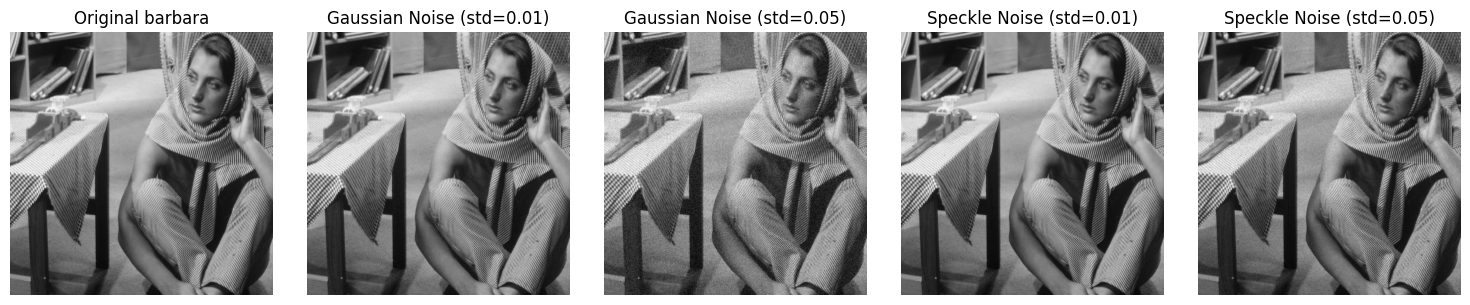

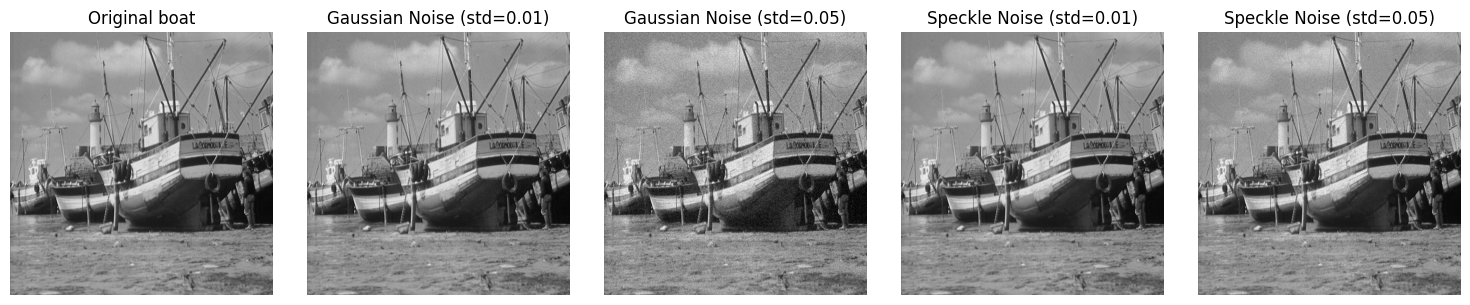

In [11]:
# 读取并归一化图像
img1 = cv2.imread(img1Path, cv2.IMREAD_GRAYSCALE) / 255.0
img2 = cv2.imread(img2Path, cv2.IMREAD_GRAYSCALE) / 255.0

# 创建保存图片的文件夹
if not os.path.exists('output'):
    os.makedirs('output')

def add_noise_and_save(img, name):
    # 添加高斯噪声 (std=0.01)
    gaussian_noise1 = np.random.normal(0, 0.01, img.shape)
    noisy_img_g1 = np.clip(img + gaussian_noise1, 0, 1)
    
    # 添加高斯噪声 (std=0.05)
    gaussian_noise2 = np.random.normal(0, 0.05, img.shape)
    noisy_img_g2 = np.clip(img + gaussian_noise2, 0, 1)
    
    # 添加斑点噪声 (std=0.01)
    speckle_noise = np.random.normal(0, 0.01, img.shape)
    noisy_img_s = np.clip(img + img * speckle_noise, 0, 1)
    
    # 添加斑点噪声 (std=0.05)
    speckle_noise2 = np.random.normal(0, 0.05, img.shape)
    noisy_img_s2 = np.clip(img + img * speckle_noise2, 0, 1)
    
    
    # 显示结果（带标题）
    plt.figure(figsize=(15, 3))
    
    plt.subplot(151)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original {name}')
    plt.axis('off')
    
    plt.subplot(152)
    plt.imshow(noisy_img_g1, cmap='gray')
    plt.title('Gaussian Noise (std=0.01)')
    plt.axis('off')
    
    plt.subplot(153)
    plt.imshow(noisy_img_g2, cmap='gray')
    plt.title('Gaussian Noise (std=0.05)')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(noisy_img_s, cmap='gray')
    plt.title('Speckle Noise (std=0.01)')
    plt.axis('off')
    
    plt.subplot(155)
    plt.imshow(noisy_img_s2, cmap='gray')
    plt.title('Speckle Noise (std=0.05)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 保存图片（不带标题）
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(f'output/original_{name}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(noisy_img_g1, cmap='gray')
    plt.axis('off')
    plt.savefig(f'output/gaussian_noise_001_{name}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(noisy_img_g2, cmap='gray')
    plt.axis('off')
    plt.savefig(f'output/gaussian_noise_005_{name}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(noisy_img_s, cmap='gray')
    plt.axis('off')
    plt.savefig(f'output/speckle_noise_{name}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(noisy_img_s2, cmap='gray')
    plt.axis('off')
    plt.savefig(f'output/speckle_noise_005_{name}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    return noisy_img_g1, noisy_img_g2, noisy_img_s, noisy_img_s2


# 处理第一张图片 (barbara)
noisy_img1_g1, noisy_img1_g2, noisy_img1_s1, noisy_img1_s2 = add_noise_and_save(img1, 'barbara')

# 处理第二张图片 (boat)
noisy_img2_g1, noisy_img2_g2, noisy_img2_s1, noisy_img2_s2 = add_noise_and_save(img2, 'boat')


In [13]:

import bm3d

def bm3d_denoising(img, sigma_psd):
    """
    使用BM3D算法进行图像去噪
    
    参数:
        img: 输入的噪声图像
        sigma_psd: 噪声标准差
    """
    return bm3d.bm3d(img, sigma_psd=sigma_psd)


def mean_filter(img, kernel_size=3):
    """
    应用均值滤波器进行去噪
    参数:
        img: 输入的噪声图像
        kernel_size: 滤波器核的大小
    """
    return cv2.blur(img, (kernel_size, kernel_size))

def wavelet_denoising(img, wavelet='db8', level=2, threshold_mode='soft'):
    """
    使用小波变换进行图像去噪
    
    参数:
        img: 输入的噪声图像
        wavelet: 小波类型
        level: 分解级别
        threshold_mode: 阈值模式 ('soft' 或 'hard')
    """
    # 小波分解
    coeffs = pywt.wavedec2(img, wavelet, level=level)
    
    # 计算阈值
    sigma = 0.06  # 估计噪声标准差
    threshold = sigma * np.sqrt(2 * np.log(img.size))
    
    # 应用阈值 - 正确处理元组结构
    new_coeffs = [coeffs[0]]  # 保留近似系数
    
    # 处理细节系数
    for i in range(1, len(coeffs)):
        detail_coeffs = []
        for j in range(3):  # 每个级别有3个细节系数 (水平、垂直、对角线)
            if threshold_mode == 'soft':
                detail_coeffs.append(pywt.threshold(coeffs[i][j], threshold, mode='soft'))
            else:
                detail_coeffs.append(pywt.threshold(coeffs[i][j], threshold, mode='hard'))
        new_coeffs.append(tuple(detail_coeffs))
    
    # 小波重构
    denoised_img = pywt.waverec2(new_coeffs, wavelet)
    
    # 处理边界效应，确保输出图像与输入图像大小相同
    if denoised_img.shape != img.shape:
        denoised_img = denoised_img[:img.shape[0], :img.shape[1]]
    
    # 确保像素值在[0,1]范围内
    denoised_img = np.clip(denoised_img, 0, 1)
    
    return denoised_img


def apply_and_compare_denoising(noisy_img, original_img, noise_type, img_name):
    """
    应用均值滤波、小波变换和BM3D去噪，并比较结果
    """
    # 均值滤波 (5x5)
    denoised_mean_5x5 = mean_filter(noisy_img, 5)
    
    # 小波变换去噪 (硬阈值)
    denoised_wavelet_hard = wavelet_denoising(noisy_img, threshold_mode='hard')
    
    # BM3D去噪
    sigma_psd = 0.05 if '005' in noise_type else 0.01  # 根据噪声类型选择合适的sigma值
    denoised_bm3d = bm3d_denoising(noisy_img, sigma_psd)
    
    # 计算PSNR
    psnr_noisy = cv2.PSNR(noisy_img, original_img)
    psnr_mean_5x5 = cv2.PSNR(denoised_mean_5x5, original_img)
    psnr_wavelet_hard = cv2.PSNR(denoised_wavelet_hard, original_img)
    psnr_bm3d = cv2.PSNR(denoised_bm3d, original_img)
    
    # 计算SSIM
    ssim_noisy = ssim(original_img, noisy_img, data_range=1.0)
    ssim_mean_5x5 = ssim(original_img, denoised_mean_5x5, data_range=1.0)
    ssim_wavelet_hard = ssim(original_img, denoised_wavelet_hard, data_range=1.0)
    ssim_bm3d = ssim(original_img, denoised_bm3d, data_range=1.0)
    
    # 显示结果 (5个子图)
    plt.figure(figsize=(15, 3))
    
    plt.subplot(151)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(152)
    plt.imshow(noisy_img, cmap='gray')
    plt.title(f'{noise_type}\nPSNR: {psnr_noisy:.2f}dB\nSSIM: {ssim_noisy:.3f}')
    plt.axis('off')
    
    plt.subplot(153)
    plt.imshow(denoised_mean_5x5, cmap='gray')
    plt.title(f'Mean 5x5\nPSNR: {psnr_mean_5x5:.2f}dB\nSSIM: {ssim_mean_5x5:.3f}')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(denoised_wavelet_hard, cmap='gray')
    plt.title(f'Wavelet (Hard)\nPSNR: {psnr_wavelet_hard:.2f}dB\nSSIM: {ssim_wavelet_hard:.3f}')
    plt.axis('off')
    
    plt.subplot(155)
    plt.imshow(denoised_bm3d, cmap='gray')
    plt.title(f'BM3D\nPSNR: {psnr_bm3d:.2f}dB\nSSIM: {ssim_bm3d:.3f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 保存结果
    # ... existing code ...
    
    bm3d_path = f'output/bm3d_{noise_type}_{img_name}.png'
    plt.figure()
    plt.imshow(denoised_bm3d, cmap='gray')
    plt.axis('off')
    plt.savefig(bm3d_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"已保存BM3D结果: {bm3d_path}")
    print(f"BM3D - PSNR: {psnr_bm3d:.2f}dB, SSIM: {ssim_bm3d:.3f}")
    print("-" * 50)
    
    # 返回结果
    return {
        'mean_5x5': {'image': denoised_mean_5x5, 'psnr': psnr_mean_5x5, 'ssim': ssim_mean_5x5},
        'wavelet_hard': {'image': denoised_wavelet_hard, 'psnr': psnr_wavelet_hard, 'ssim': ssim_wavelet_hard},
        'bm3d': {'image': denoised_bm3d, 'psnr': psnr_bm3d, 'ssim': ssim_bm3d}
    }


Processing Barbara image with Wavelet Transform:


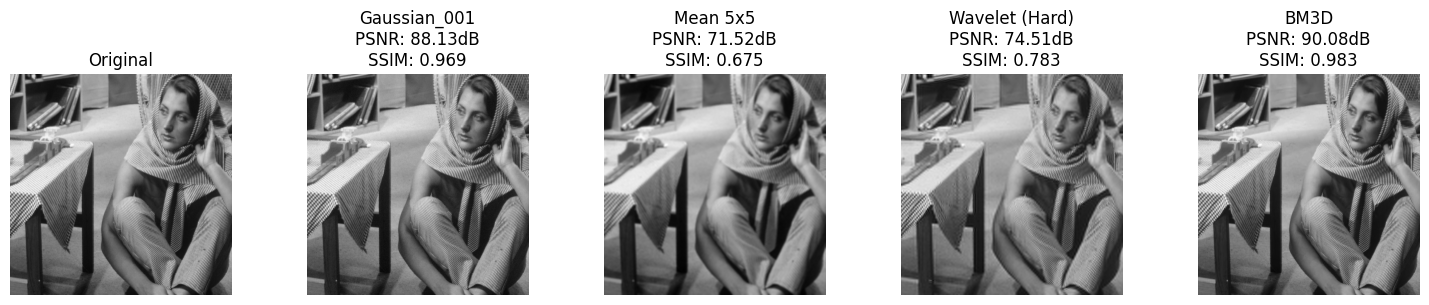

已保存BM3D结果: output/bm3d_Gaussian_001_barbara.png
BM3D - PSNR: 90.08dB, SSIM: 0.983
--------------------------------------------------


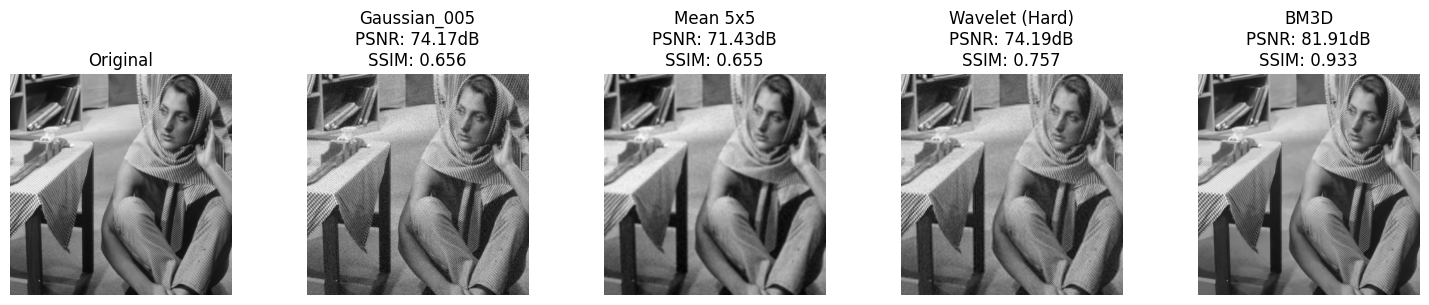

已保存BM3D结果: output/bm3d_Gaussian_005_barbara.png
BM3D - PSNR: 81.91dB, SSIM: 0.933
--------------------------------------------------


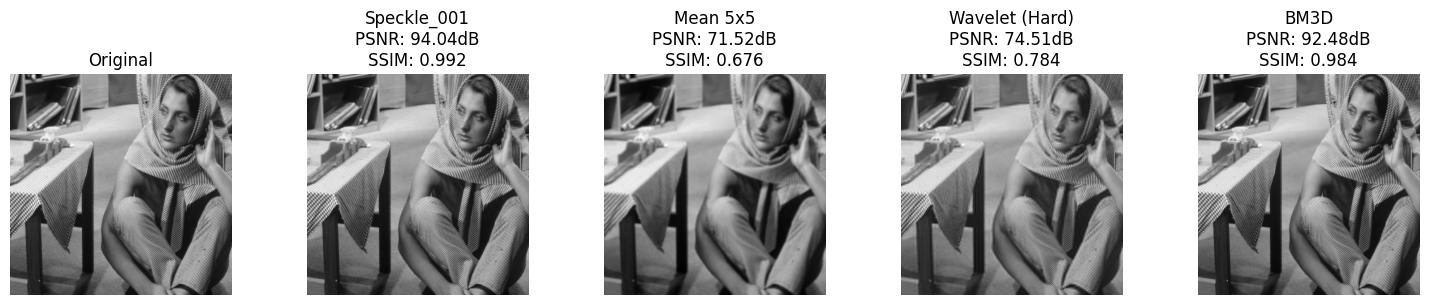

已保存BM3D结果: output/bm3d_Speckle_001_barbara.png
BM3D - PSNR: 92.48dB, SSIM: 0.984
--------------------------------------------------


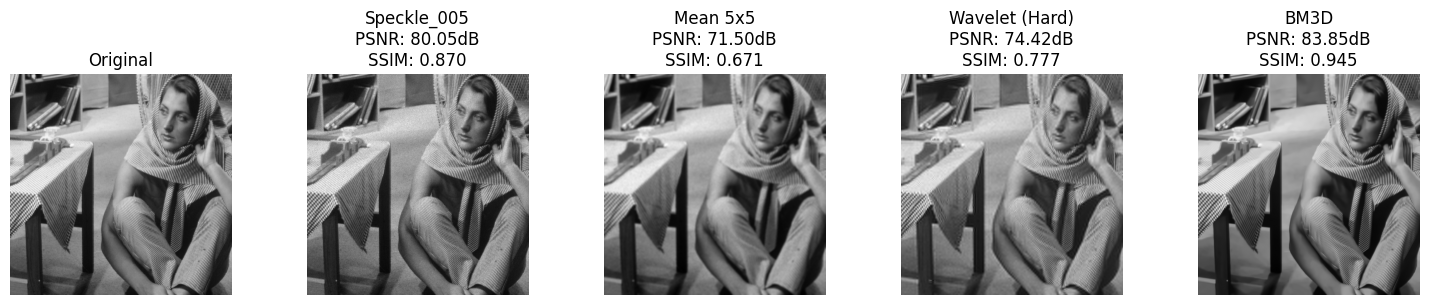

已保存BM3D结果: output/bm3d_Speckle_005_barbara.png
BM3D - PSNR: 83.85dB, SSIM: 0.945
--------------------------------------------------

Processing Boat image with Wavelet Transform:


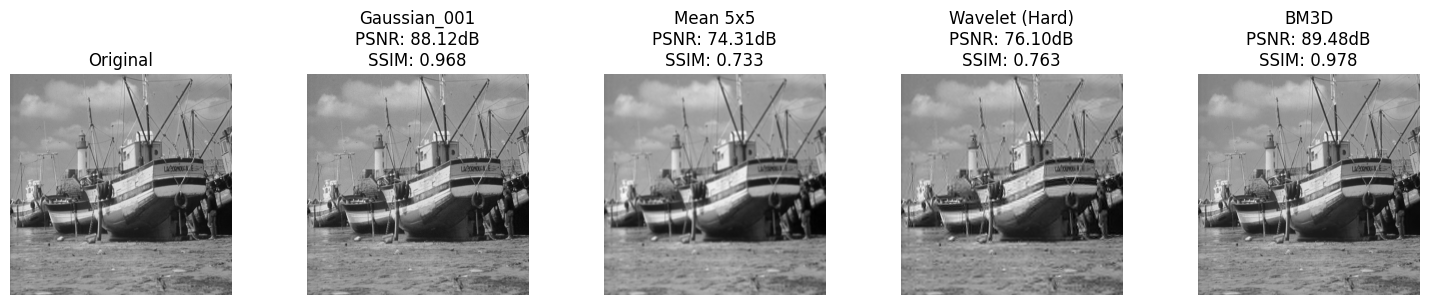

已保存BM3D结果: output/bm3d_Gaussian_001_boat.png
BM3D - PSNR: 89.48dB, SSIM: 0.978
--------------------------------------------------


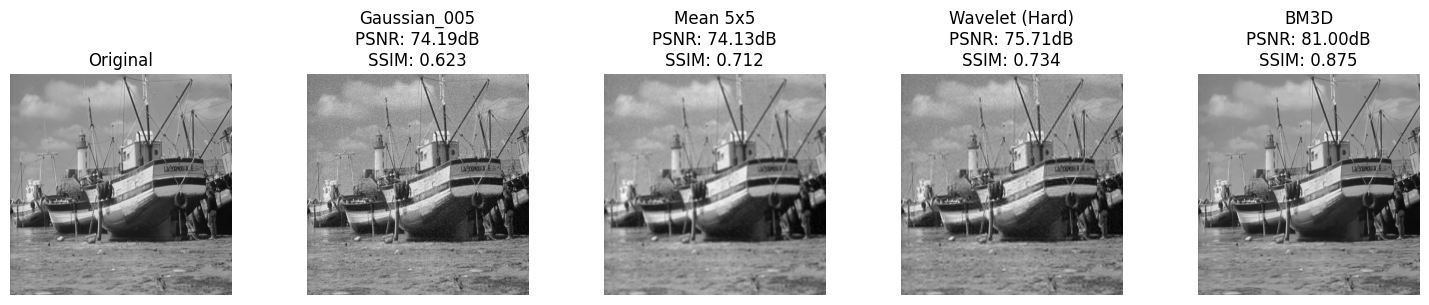

已保存BM3D结果: output/bm3d_Gaussian_005_boat.png
BM3D - PSNR: 81.00dB, SSIM: 0.875
--------------------------------------------------


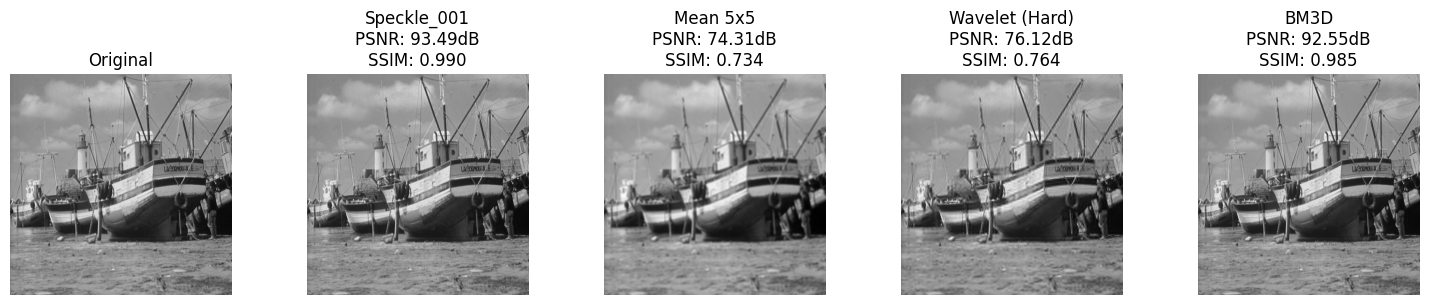

已保存BM3D结果: output/bm3d_Speckle_001_boat.png
BM3D - PSNR: 92.55dB, SSIM: 0.985
--------------------------------------------------


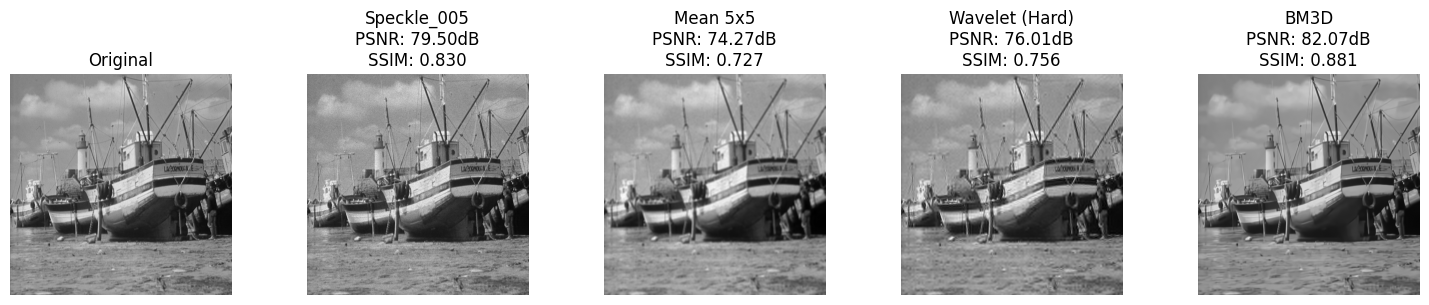

已保存BM3D结果: output/bm3d_Speckle_005_boat.png
BM3D - PSNR: 82.07dB, SSIM: 0.881
--------------------------------------------------


In [14]:
  
# 处理barbara图像的所有噪声版本
print("Processing Barbara image with Wavelet Transform:")
# 高斯噪声 (std=0.01)
results_b_g1 = apply_and_compare_denoising(noisy_img1_g1, img1, 'Gaussian_001', 'barbara')

# 高斯噪声 (std=0.05)
results_b_g2 = apply_and_compare_denoising(noisy_img1_g2, img1, 'Gaussian_005', 'barbara')

# 斑点噪声 (std=0.01)
results_b_s1 = apply_and_compare_denoising(noisy_img1_s1, img1, 'Speckle_001', 'barbara')

# 斑点噪声 (std=0.05)
results_b_s2 = apply_and_compare_denoising(noisy_img1_s2, img1, 'Speckle_005', 'barbara')

# 处理boat图像的所有噪声版本
print("\nProcessing Boat image with Wavelet Transform:")
# 高斯噪声 (std=0.01)
results_bt_g1 = apply_and_compare_denoising(noisy_img2_g1, img2, 'Gaussian_001', 'boat')

# 高斯噪声 (std=0.05)
results_bt_g2 = apply_and_compare_denoising(noisy_img2_g2, img2, 'Gaussian_005', 'boat')

# 斑点噪声 (std=0.01)
results_bt_s1 = apply_and_compare_denoising(noisy_img2_s1, img2, 'Speckle_001', 'boat')

# 斑点噪声 (std=0.05)
results_bt_s2 = apply_and_compare_denoising(noisy_img2_s2, img2, 'Speckle_005', 'boat')

Processing Barbara image with KSVD:


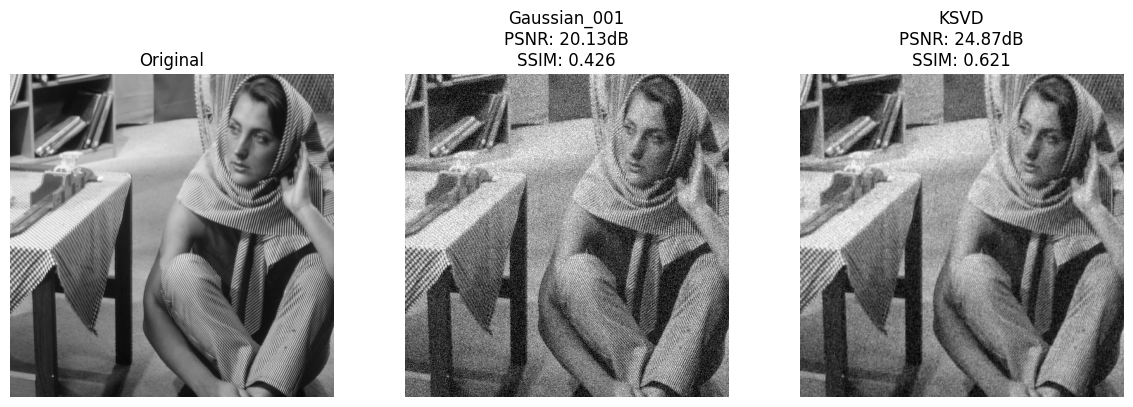

已保存 KSVD 结果: output/ksvd_Gaussian_001_barbara.png
KSVD - PSNR: 24.87dB, SSIM: 0.621
--------------------------------------------------


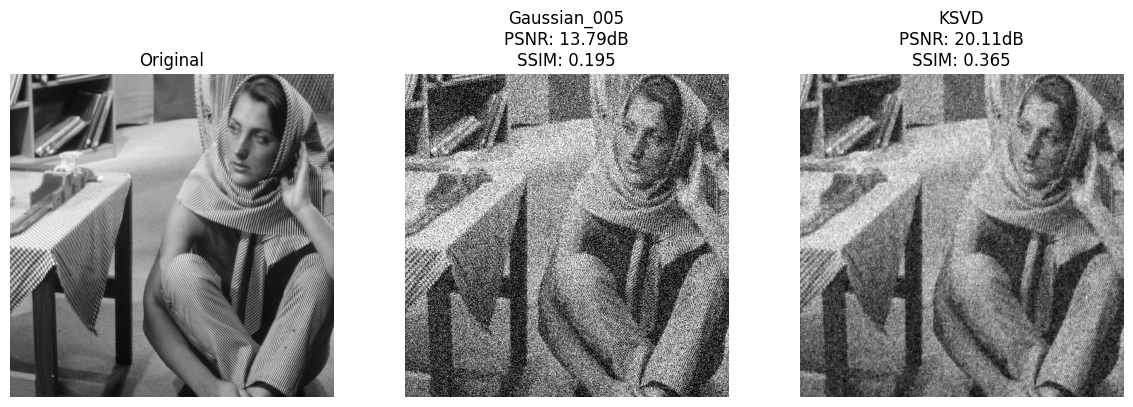

已保存 KSVD 结果: output/ksvd_Gaussian_005_barbara.png
KSVD - PSNR: 20.11dB, SSIM: 0.365
--------------------------------------------------


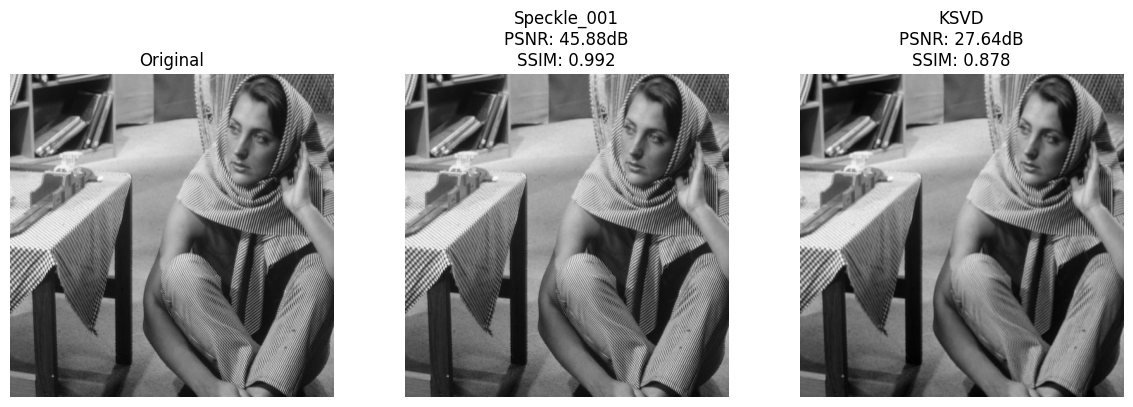

已保存 KSVD 结果: output/ksvd_Speckle_001_barbara.png
KSVD - PSNR: 27.64dB, SSIM: 0.878
--------------------------------------------------


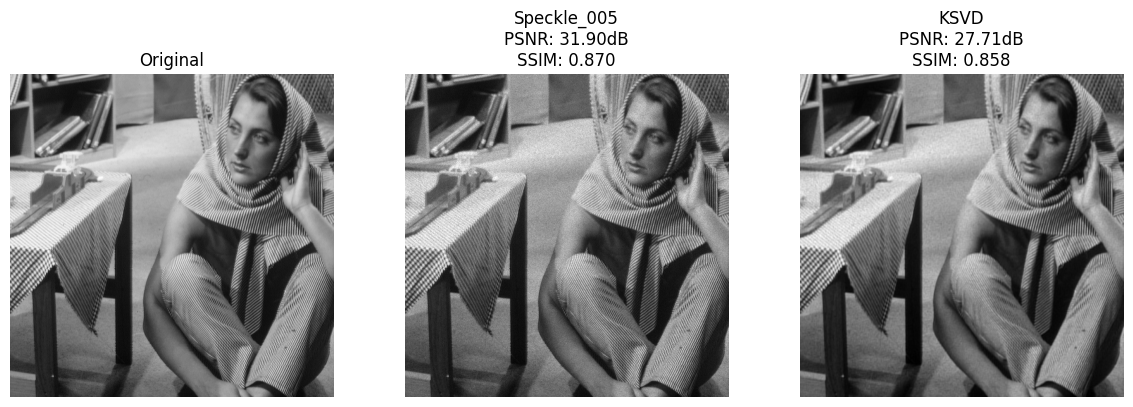

已保存 KSVD 结果: output/ksvd_Speckle_005_barbara.png
KSVD - PSNR: 27.71dB, SSIM: 0.858
--------------------------------------------------

Processing Boat image with KSVD:


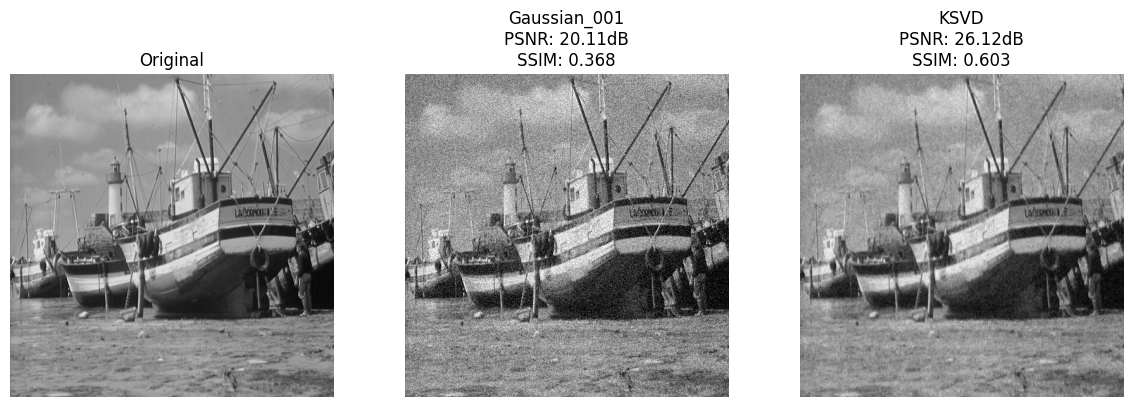

已保存 KSVD 结果: output/ksvd_Gaussian_001_boat.png
KSVD - PSNR: 26.12dB, SSIM: 0.603
--------------------------------------------------


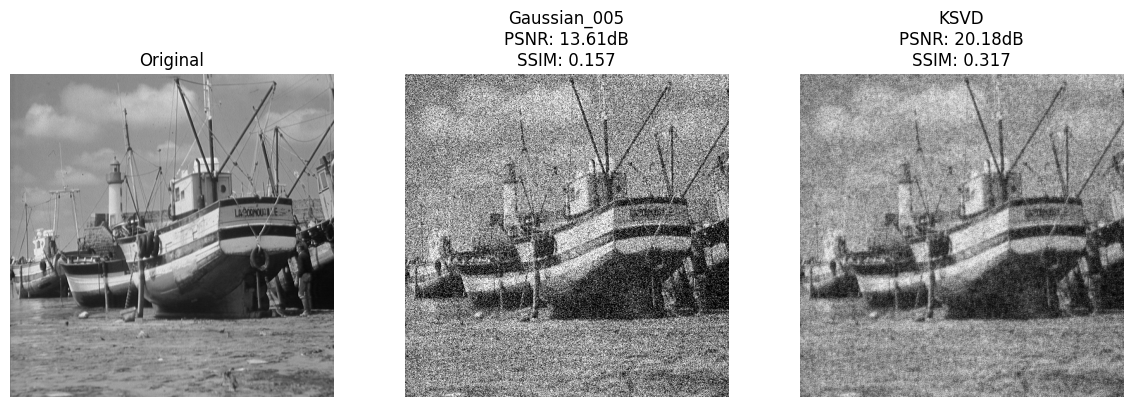

已保存 KSVD 结果: output/ksvd_Gaussian_005_boat.png
KSVD - PSNR: 20.18dB, SSIM: 0.317
--------------------------------------------------


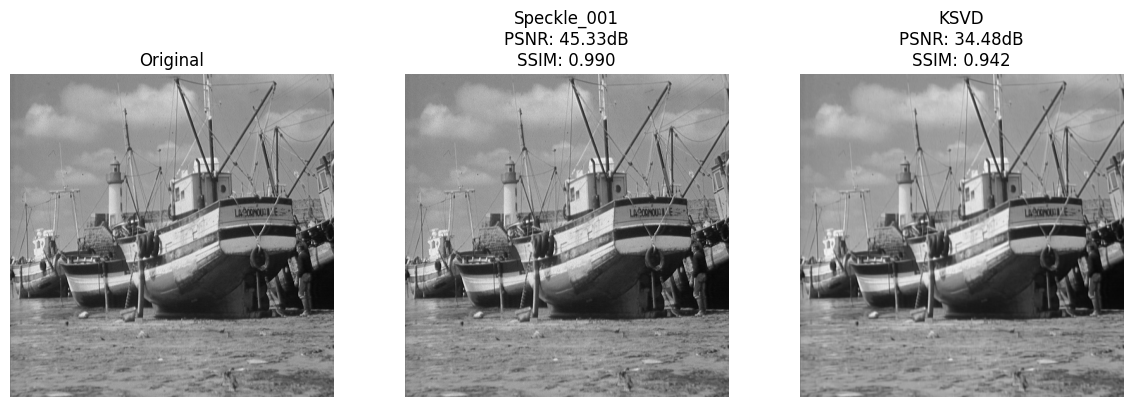

已保存 KSVD 结果: output/ksvd_Speckle_001_boat.png
KSVD - PSNR: 34.48dB, SSIM: 0.942
--------------------------------------------------


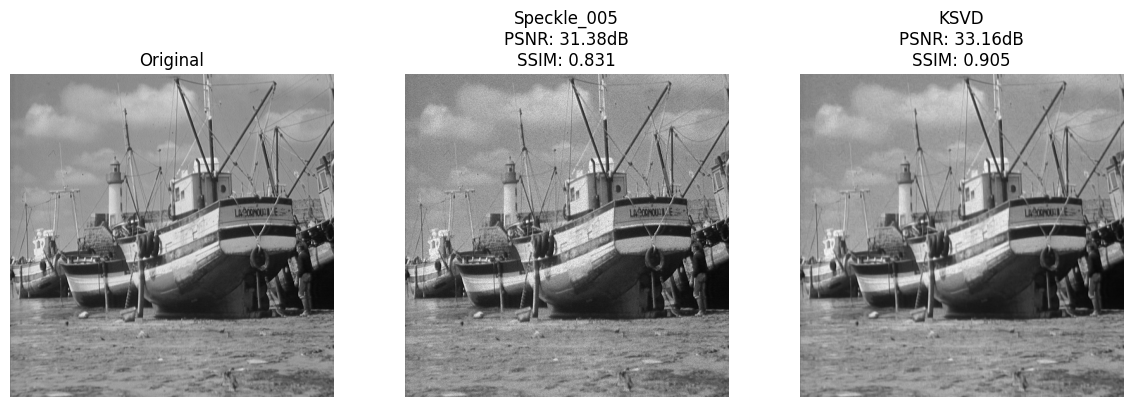

已保存 KSVD 结果: output/ksvd_Speckle_005_boat.png
KSVD - PSNR: 33.16dB, SSIM: 0.905
--------------------------------------------------


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util
from sklearn.feature_extraction import image
from ksvd import ApproximateKSVD
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# KSVD 去噪函数
def ksvd_denoising(img, patch_size=(5, 5), n_components=32):
    """
    使用 KSVD 算法进行图像去噪
    
    参数:
        img: 输入的噪声图像
        patch_size: 图像块大小
        n_components: 字典学习的组件数
    返回:
        去噪后的图像
    """
    # 提取图像块
    patches = image.extract_patches_2d(img, patch_size)
    signals = patches.reshape(patches.shape[0], -1)
    
    # 对信号进行去均值处理
    mean = np.mean(signals, axis=1)[:, np.newaxis]
    signals -= mean
    
    # 使用 Approximate KSVD 进行字典学习
    aksvd = ApproximateKSVD(n_components=n_components)
    dictionary = aksvd.fit(signals[:10000]).components_
    
    # 使用学习到的字典对信号进行稀疏编码
    gamma = aksvd.transform(signals)
    
    # 重建信号
    reduced = gamma.dot(dictionary) + mean
    reduced_img = image.reconstruct_from_patches_2d(
        reduced.reshape(patches.shape), img.shape)
    
    # 将像素值限制在 [0, 1] 范围内
    return np.clip(reduced_img, 0, 1)

# 显示原图、加噪声图像和 KSVD 去噪结果
def show_ksvd_results(original_img, noisy_img, noise_type, img_name):
    """
    应用 KSVD 去噪，并显示原图、加噪声图像和 KSVD 去噪结果
    """
    # KSVD 去噪
    denoised_ksvd = ksvd_denoising(noisy_img)
    
    # 计算 PSNR 和 SSIM
    psnr_noisy = psnr(original_img, noisy_img, data_range=1.0)
    psnr_ksvd = psnr(original_img, denoised_ksvd, data_range=1.0)
    
    ssim_noisy = ssim(original_img, noisy_img, data_range=1.0)
    ssim_ksvd = ssim(original_img, denoised_ksvd, data_range=1.0)
    
    # 显示结果 (3个子图)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(noisy_img, cmap='gray')
    plt.title(f'{noise_type}\nPSNR: {psnr_noisy:.2f}dB\nSSIM: {ssim_noisy:.3f}')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(denoised_ksvd, cmap='gray')
    plt.title(f'KSVD\nPSNR: {psnr_ksvd:.2f}dB\nSSIM: {ssim_ksvd:.3f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 保存 KSVD 结果
    ksvd_path = f'output/ksvd_{noise_type}_{img_name}.png'
    plt.figure()
    plt.imshow(denoised_ksvd, cmap='gray')
    plt.axis('off')
    plt.savefig(ksvd_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"已保存 KSVD 结果: {ksvd_path}")
    print(f"KSVD - PSNR: {psnr_ksvd:.2f}dB, SSIM: {ssim_ksvd:.3f}")
    print("-" * 50)
    
    # 返回结果
    return {'image': denoised_ksvd, 'psnr': psnr_ksvd, 'ssim': ssim_ksvd}

# 示例：加载图像并添加噪声
if __name__ == "__main__":
    # 加载原始图像
    img1 = util.img_as_float(io.imread("images/barbara.png", as_gray=True))
    img2 = util.img_as_float(io.imread("images/boat.png", as_gray=True))
    
    # 添加高斯噪声
    noisy_img1_g1 = util.random_noise(img1, mode='gaussian', var=0.01)
    noisy_img1_g2 = util.random_noise(img1, mode='gaussian', var=0.05)
    noisy_img2_g1 = util.random_noise(img2, mode='gaussian', var=0.01)
    noisy_img2_g2 = util.random_noise(img2, mode='gaussian', var=0.05)
    
    # 处理 barbara 图像的所有噪声版本
    print("Processing Barbara image with KSVD:")
    results_b_g1 = show_ksvd_results(img1, noisy_img1_g1, 'Gaussian_001', 'barbara')
    results_b_g2 = show_ksvd_results(img1, noisy_img1_g2, 'Gaussian_005', 'barbara')
    
    results_b_s1 = show_ksvd_results(img1, noisy_img1_s1, 'Speckle_001', 'barbara')
    results_b_s5 = show_ksvd_results(img1, noisy_img1_s2, 'Speckle_005', 'barbara')
    

    # 处理 boat 图像的所有噪声版本
    print("\nProcessing Boat image with KSVD:")
    results_bt_g1 = show_ksvd_results(img2, noisy_img2_g1, 'Gaussian_001', 'boat')
    results_bt_g2 = show_ksvd_results(img2, noisy_img2_g2, 'Gaussian_005', 'boat')
    results_bt_g1 = show_ksvd_results(img2, noisy_img2_s1, 'Speckle_001', 'boat')
    results_bt_g2 = show_ksvd_results(img2, noisy_img2_s2, 'Speckle_005', 'boat')